# **🎥 Film Junky Union 🎥**

## **Project Description**
The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to reach an F1 score of at least 0.85.

### **Project Instructions**
  1. Load the data
  2. Pre-process the data
  3. Conduct an EDA and make your conclusion on the class imbalance
  4. Pre-process the data for modeling
  5. Train at least three different models for the given train dataset
  6. Test the models for the given test dataset
  7. Compose a few of your own reviews and classify them with all the models
  8. Check for differences between the testing results of models in the above two points. Try to explain them.
  9. Present your findings

# **Initialization**

In [ ]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import sklearn.metrics as metrics

import re

In [ ]:
%matplotlib inline # This is a magic command that tells Jupyter to display Matplotlib plots inline within the notebook, directly below the code cells that produce them. This means that when you create a plot, it will appear in the notebook instead of in a separate window.

%config InlineBackend.figure_format = 'png' # This line configures the inline backend to render figures in PNG format. PNG is a raster graphics format that is widely supported and provides a good balance of quality and file size for most plots.

%config InlinBackend.figure_format = 'retina' #

plt.style.use('seaborn')

UsageError: unrecognized arguments: # This is a magic command that tells Jupyter to display Matplotlib plots inline within the notebook, directly below the code cells that produce them. This means that when you create a plot, it will appear in the notebook instead of in a separate window.


In [ ]:
tqdm.pandas()

# **Load Data**

In [ ]:
df_reviews = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [ ]:
print(df_reviews.head(10))

print(df_reviews.info())

display(df_reviews.describe())

      tconst title_type                                      primary_title  \
0  tt0068152      movie                                                  $   
1  tt0068152      movie                                                  $   
2  tt0313150      short                                               '15'   
3  tt0313150      short                                               '15'   
4  tt0313150      short                                               '15'   
5  tt0313150      short                                               '15'   
6  tt0313150      short                                               '15'   
7  tt0035958      movie  'Gung Ho!': The Story of Carlson's Makin Islan...   
8  tt0035958      movie  'Gung Ho!': The Story of Carlson's Makin Islan...   
9  tt0035958      movie  'Gung Ho!': The Story of Carlson's Makin Islan...   

                                      original_title  start_year end_year  \
0                                                  $        1971

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,47329.0,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,25562.917323,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,83670.039163,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.0,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,827.0,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3197.0,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,13974.0,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1739448.0,10.000000,1.000000,12499.000000


## **Exploratory Data Analysis**

Let's check the number of movies and reviews over years

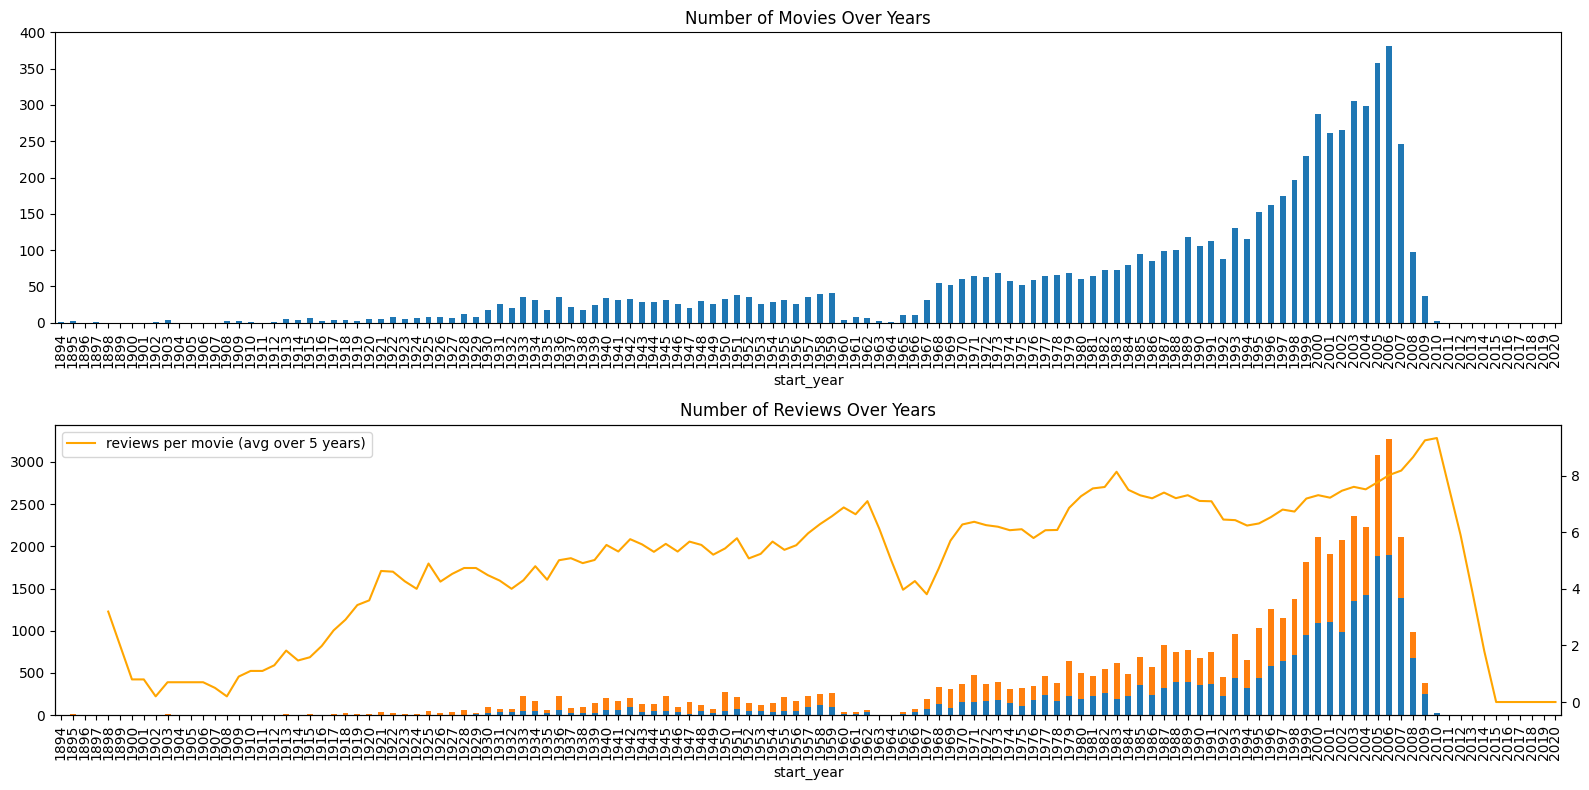

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movies with the exact counting and KDE

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [ ]:
df_reviews['pos'].value_counts()

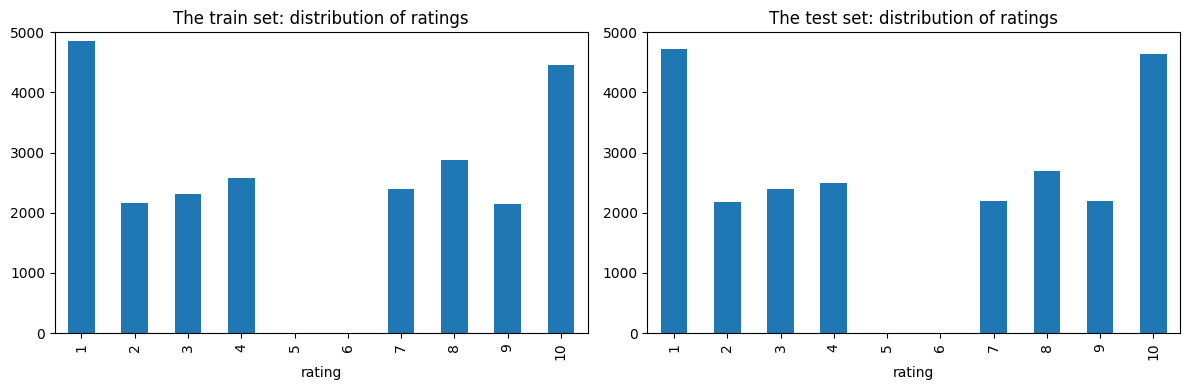

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

<ipython-input-8-e0e81b3a9b29>:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
<ipython-input-8-e0e81b3a9b29>:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
<ipython-input-8-e0e81b3a9b29>:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
<ipython-input-8-e0e81b3a9b29>:31: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  

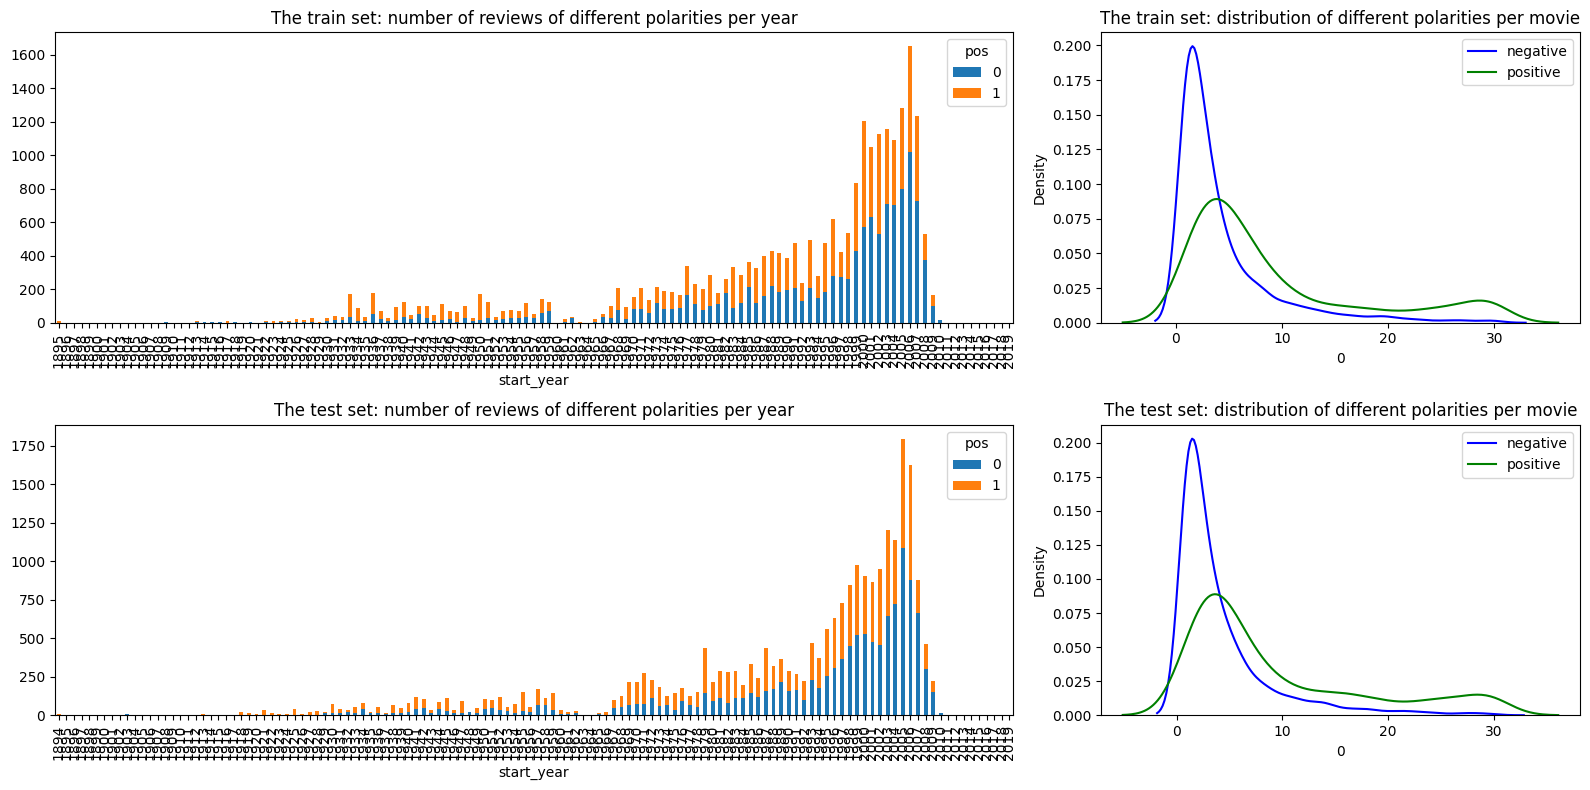

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

In [ ]:
# Class imbalance time

class_distribution1 = df_reviews['tconst'].value_counts()
print(class_distribution1)

class_distribution2 = df_reviews['title_type'].value_counts()
print(class_distribution2)

class_distribution3 = df_reviews['primary_title'].value_counts()
print(class_distribution3)

class_distribution4 = df_reviews['original_title'].value_counts()
print(class_distribution4)

class_distribution5 = df_reviews['end_year'].value_counts()
print(class_distribution5)

class_distribution6 = df_reviews['runtime_minutes'].value_counts()
print(class_distribution6)

class_distribution7 = df_reviews['genres'].value_counts()
print(class_distribution7)

class_distribution8 = df_reviews['review'].value_counts()
print(class_distribution8)

class_distribution9 = df_reviews['sp'].value_counts()
print(class_distribution9)

class_distribution10 = df_reviews['ds_part'].value_counts()
print(class_distribution5)

tconst
tt0096511    30
tt0284978    30
tt0189456    30
tt0274117    30
tt0386741    30
             ..
tt0000439     1
tt0067162     1
tt0099021     1
tt0051349     1
tt0138289     1
Name: count, Length: 6648, dtype: int64
title_type
movie           36861
tvMovie          2892
video            2742
tvSeries         2246
short             887
tvMiniSeries      713
tvEpisode         635
tvSpecial         183
videoGame         154
tvShort            18
Name: count, dtype: int64
primary_title
The Sentinel               60
The War at Home            54
Emma                       51
Jane Eyre                  49
In Cold Blood              42
                           ..
Yesterday                   1
Yesterday Once More         1
You Were Never Lovelier     1
You're Never Too Young      1
You're in the Navy Now      1
Name: count, Length: 6555, dtype: int64
original_title
The Sentinel                           60
The War at Home                        54
Emma                                 

**Commentary:**

## **Evaluation Procedure**

Composing an evaluation routine which can be used for all models in this project

In [ ]:
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'ROC Curve')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## **Normalization**

We assume all models below except texts in lowercase and without any digits, punctuations, etc.

In [ ]:
def normalize_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Apply the normalization function to create new column
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

## **Train-Test Split**

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

# Initialize the OrdinalEncoder for start_year and end_year
ordinal_encoder = OrdinalEncoder()

# Fit and transform the start_year and end_year columns
df_reviews[['start_year', 'end_year']] = ordinal_encoder.fit_transform(df_reviews[['start_year', 'end_year']])

# Initialize the LabelEncoder for genres
label_encoder = LabelEncoder()

# Fit and transform the genres column
df_reviews['genres'] = label_encoder.fit_transform(df_reviews['genres'])

# Display the modified DataFrame
print(df_reviews)

          tconst title_type                 primary_title  \
0      tt0068152      movie                             $   
1      tt0068152      movie                             $   
2      tt0313150      short                          '15'   
3      tt0313150      short                          '15'   
4      tt0313150      short                          '15'   
...          ...        ...                           ...   
47326  tt0068398  tvEpisode                Étude in Black   
47327  tt0223503    tvMovie  Îhatôbu gensô: KENjI no haru   
47328  tt0223503    tvMovie  Îhatôbu gensô: KENjI no haru   
47329  tt0223503    tvMovie  Îhatôbu gensô: KENjI no haru   
47330  tt0223503    tvMovie  Îhatôbu gensô: KENjI no haru   

                     original_title  start_year  end_year runtime_minutes  \
0                                 $        67.0      59.0             121   
1                                 $        67.0      59.0             121   
2                              '15' 

In [ ]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## **Working the Models**

### **Model 0 – Constant**

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


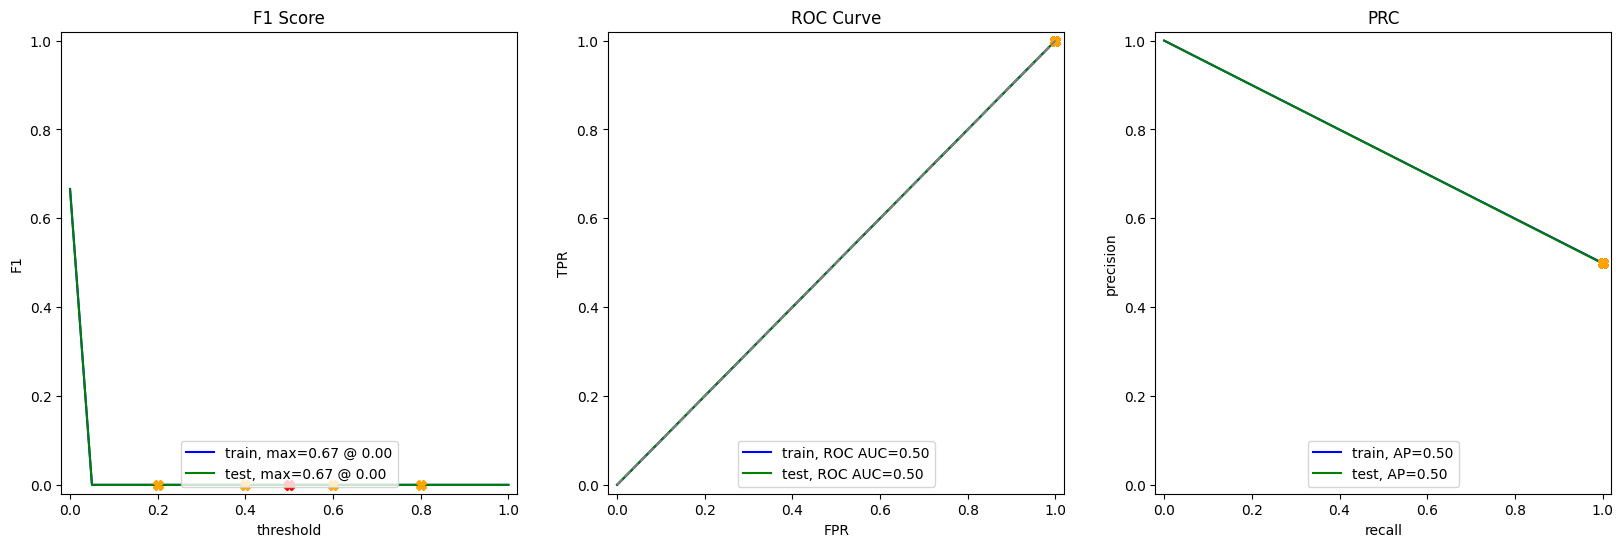

In [ ]:
from sklearn.dummy import DummyClassifier

# step 2:
features = df_reviews_train.drop(columns=['pos', 'ds_part'])  # Drop target and any non-feature columns
test_features = df_reviews_test.drop(columns=['pos', 'ds_part'])

# Step 3: Initialize the DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")  # You can choose different strategies

# Step 4: Fit the model on the training data
dummy_clf.fit(features, train_target)

# Step 5: Evaluate the model using the evaluate_model function
evaluate_model(dummy_clf, features, train_target, test_features, test_target)

### **Model 1 – NLTK, TF-IDF and LR**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.94
ROC AUC    0.98  0.95


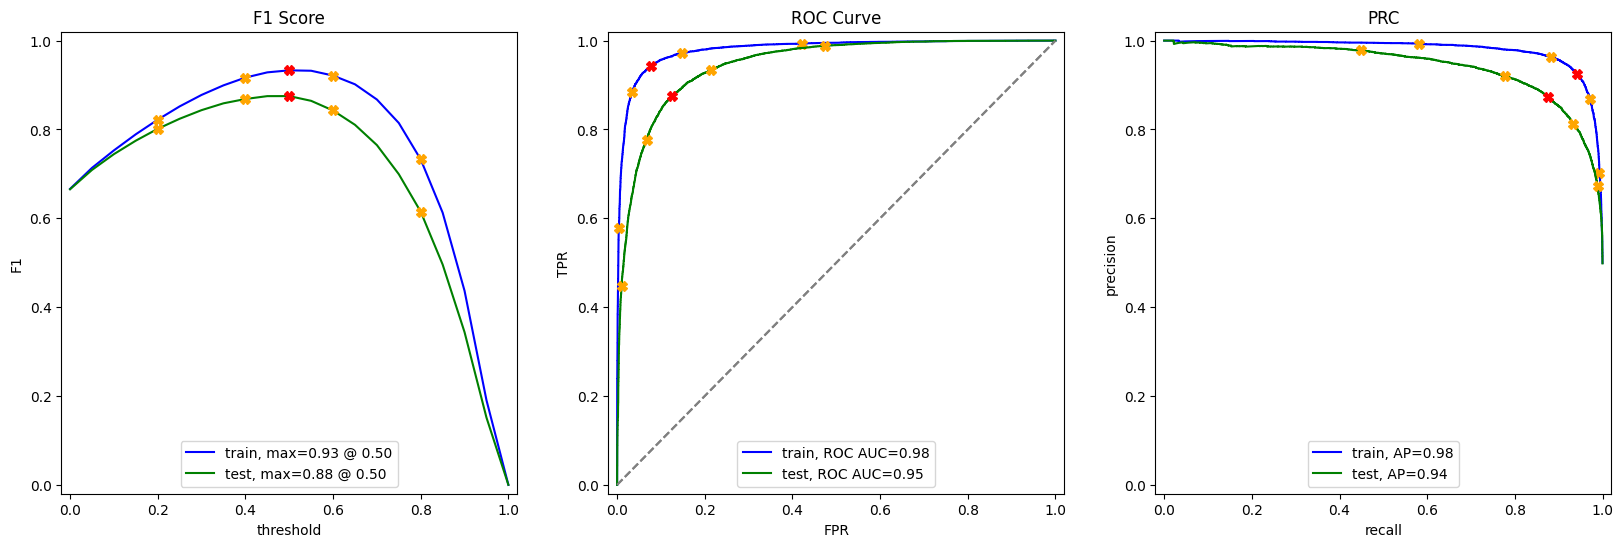

In [ ]:
import spacy
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import nltk
import matplotlib.pyplot as plt
import numpy as np

# Ensure that the NLTK stopwords are downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Load the spaCy model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Define a text preprocessing function using spaCy
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)

# Load your DataFrame
df_reviews = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

# Apply preprocessing to the 'review' column
df_reviews['processed_review'] = df_reviews['review'].apply(preprocess_text)

# Create a TfidfVectorizer object
vectorizer = TfidfVectorizer()

# Fit the vectorizer to the processed reviews and transform the data
# Note: You should fit the vectorizer on the training data only
vectorizer.fit(df_reviews['processed_review'])

# Split the data into training and testing sets
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

# Transform the reviews into TF-IDF features
train_features = vectorizer.transform(df_reviews_train['processed_review'])
test_features = vectorizer.transform(df_reviews_test['processed_review'])

# Initialize and train the Logistic Regression model
model = LogisticRegression()
model.fit(train_features, train_target)

# Now you can use the evaluate_model function to evaluate the model
evaluate_model(model, train_features, train_target, test_features, test_target)

### **Model 3 – spaCy, TF-IDF and LR**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.94
ROC AUC    0.98  0.95


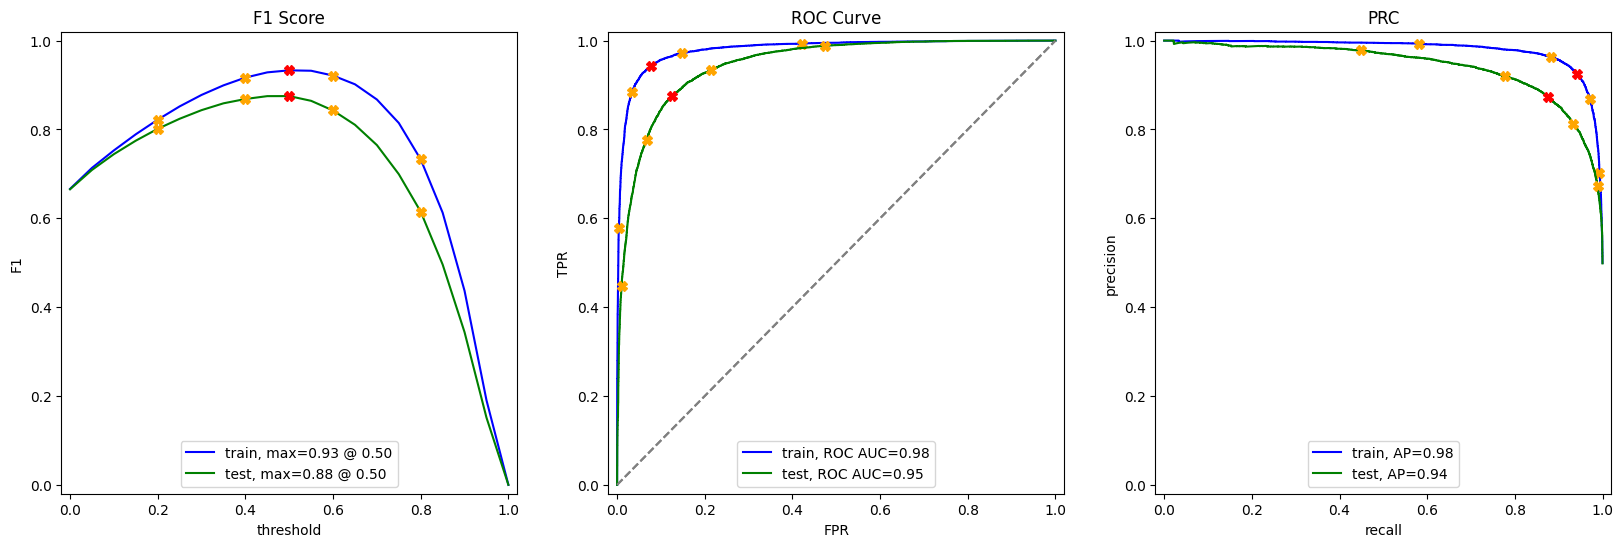

In [16]:
import spacy
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import nltk
import matplotlib.pyplot as plt
import numpy as np

# Ensure that the NLTK stopwords are downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Load the spaCy model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Define a text preprocessing function using spaCy
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)

# Load your DataFrame
df_reviews = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

# Apply preprocessing to the 'review' column
df_reviews['processed_review'] = df_reviews['review'].apply(preprocess_text)

# Create a TfidfVectorizer object
vectorizer = TfidfVectorizer()

# Fit the vectorizer to the processed reviews and transform the data
# Note: You should fit the vectorizer on the training data only
vectorizer.fit(df_reviews['processed_review'])

# Split the data into training and testing sets
df_reviews_train2 = df_reviews.query('ds_part == "train"').copy()
df_reviews_test2 = df_reviews.query('ds_part == "test"').copy()

train_target2 = df_reviews_train2['pos']
test_target2 = df_reviews_test2['pos']

# Transform the reviews into TF-IDF features
train_features2 = vectorizer.transform(df_reviews_train['processed_review'])
test_features2 = vectorizer.transform(df_reviews_test['processed_review'])

# Initialize and train the Logistic Regression model
model2 = LogisticRegression()
model2.fit(train_features2, train_target2)

# Now you can use the evaluate_model function to evaluate the model
evaluate_model(model2, train_features2, train_target2, test_features2, test_target2)

### **Model 4 – spaCy, TF-IDF, LGBMClassifier**

In [17]:
!pip install lightgbm

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.817057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 438518
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9541
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
          train  test
Accuracy   0.91  0.85
F1         0.91  0.85
APS        0.97  0.93
ROC AUC    0.97  0.93


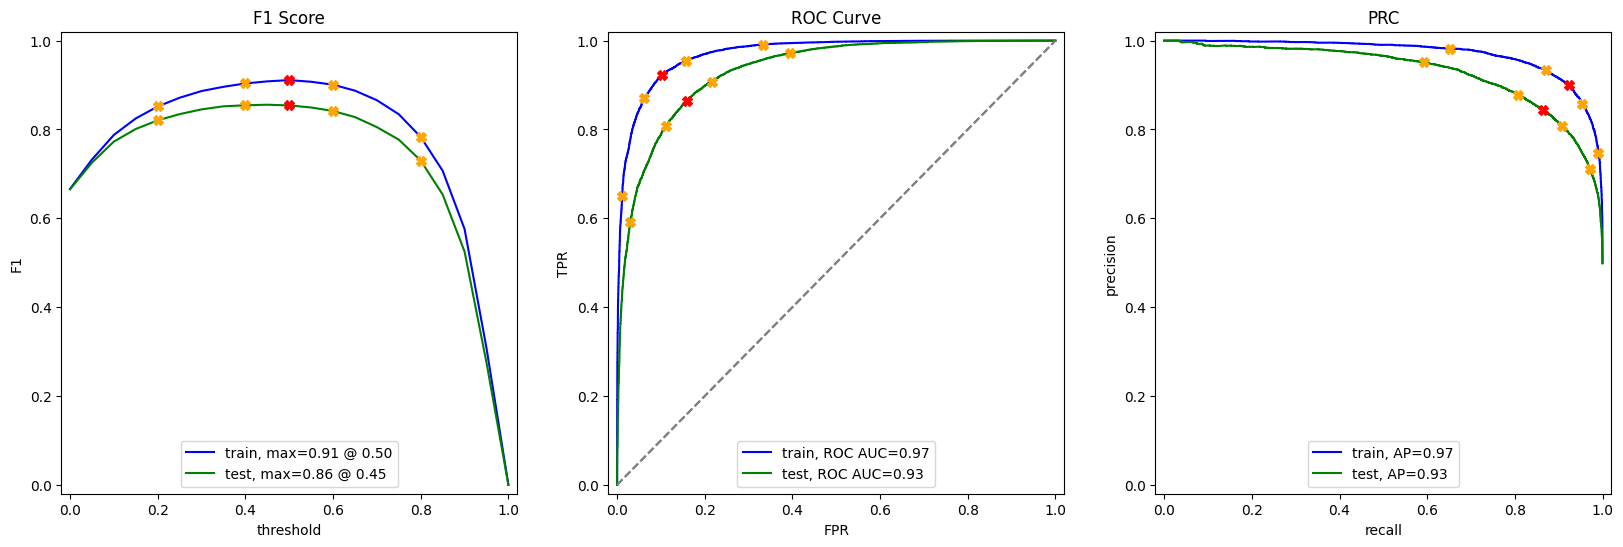

In [18]:
from lightgbm import LGBMClassifier

# Add code
train_target3 = df_reviews_train['pos']
test_target3 = df_reviews_test['pos']

# Transform the reviews into TF-IDF features
train_features3 = vectorizer.transform(df_reviews_train['processed_review'])
test_features3 = vectorizer.transform(df_reviews_test['processed_review'])

# Initialize and train the LGBMClassifier model
model3 = LGBMClassifier()
model3.fit(train_features3, train_target3)

# Now you can use the evaluate_model function to evaluate the model
evaluate_model(model3, train_features3, train_target3, test_features3, test_target3)

### **Model 9 – BERT**

In [19]:
import torch
import transformers

tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [20]:
import pandas as pd
import numpy as np
import torch
import transformers
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

# Load your DataFrame
df_reviews = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

# Split the data into training and testing sets
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

# Initialize BERT components
tokenizer = transformers.BertTokenizerFast.from_pretrained('bert-base-uncased')  # Use BertTokenizerFast
model = transformers.BertModel.from_pretrained('bert-base-uncased')

def BERT_text_to_embeddings(texts, max_length=512, batch_size=250, force_device=None, disable_progress_bar=False):
    # Use tokenizer to encode the texts
    encodings = tokenizer(
        texts,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    ids_list = encodings['input_ids']
    attention_mask_list = encodings['attention_mask']

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')

    # Getting embeddings in batches
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
        ids_batch = ids_list[batch_size*i:batch_size*(i+1)].to(device)
        attention_mask_batch = attention_mask_list[batch_size*i:batch_size*(i+1)].to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:, 0, :].detach().cpu().numpy())

    return np.concatenate(embeddings)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [21]:
# Get embeddings for train and test sets
# Convert the 'review' field to a list of strings before getting embeddings
train_reviews = df_reviews_train['review'].astype(str).tolist()
test_reviews = df_reviews_test['review'].astype(str).tolist()

# Get embeddings for train and test sets
train_features_9 = BERT_text_to_embeddings(train_reviews)
test_features_9 = BERT_text_to_embeddings(test_reviews)

print(df_reviews_train['review'].shape)
print(train_features_9.shape)
print(train_target.shape)

Using the cuda device.


100%|██████████| 96/96 [02:12<00:00,  1.38s/it]


Using the cuda device.


100%|██████████| 95/95 [02:08<00:00,  1.35s/it]


(23796,)
(23796, 768)
(23796,)


[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
          train  test
Accuracy   0.93  0.85
F1         0.93  0.85
APS        0.98  0.93
ROC AUC    0.98  0.93


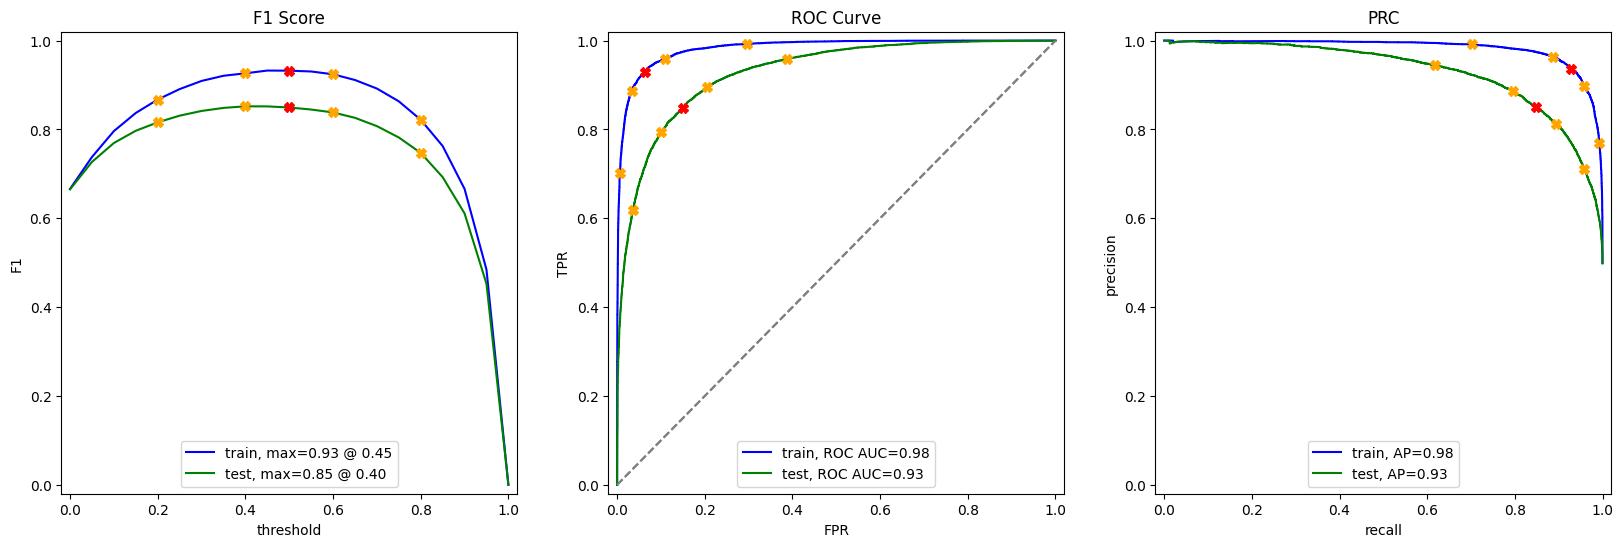

In [22]:
# Initialize and train the LGBMClassifier model
model = LGBMClassifier()
model.fit(train_features_9, train_target)

# Now you can use the evaluate_model function to evaluate the model
evaluate_model(model, train_features_9, train_target, test_features_9, test_target)

## **My Reviews**

In [24]:
import pandas as pd
import re
import string

# Sample DataFrame creation for demonstration
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie. This movie was poopie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie, but it was still kind of poopie.',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

# Define a normalization function
def normalize_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the normalization function to the 'review' column
my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)

# Display the normalized reviews
print(my_reviews)

                                              review  \
0  I did not simply like it, not my kind of movie...   
1  Well, I was bored and felt asleep in the middl...   
2  I was really fascinated with the movie, but it...   
3  Even the actors looked really old and disinter...   
4  I didn't expect the reboot to be so good! Writ...   
5  The movie had its upsides and downsides, but I...   
6  What a rotten attempt at a comedy. Not a singl...   
7  Launching on Netflix was a brave move & I real...   

                                         review_norm  
0  i did not simply like it not my kind of movie ...  
1  well i was bored and felt asleep in the middle...  
2  i was really fascinated with the movie but it ...  
3  even the actors looked really old and disinter...  
4  i didnt expect the reboot to be so good writer...  
5  the movie had its upsides and downsides but i ...  
6  what a rotten attempt at a comedy not a single...  
7  launching on netflix was a brave move i really...  


### **Model 2**

In [28]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model3.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

NameError: name 'tfidf_vectorizer_2' is not defined

### **Model 3**

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### **Model 4**

In [ ]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### **Model 9**

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## **Conclusions**

< add here >